In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns 
import h5py
import pandas as pd
import scipy

from sklearn.decomposition import PCA

# Dimension reduction and clustering libraries
import umap
import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

In [2]:
# function to extract info from Tapestri H5 files
def extract_tapestri(tapestri_file):
    '''
    INPUT: A Tapestri CNV + SNV file in HD5 format
    OUTPUT:
        1. cells: Dataframe of information about all selected cells
        2. amplicons: Dataframe of information for targeted amplicons
        3. read_counts: Dataframe of sequencing read counts per cell barcode (index) and amplicon (columns)
        4: variants: Dataframe of information for inferred SNVs
        5. vafs : Dataframe of variant allele frequencies per cell barcode (index) and SNV (columns)
        6. covs : Dataframe of total sequencing coverage per cell barcode (index) and SNV (columns)
        7. filtermask: Dataframe of filtered masks per cell barcode (index) and SNV (columns)
        8. gqs: Dataframe of VCF-score GQS per cell barcode (index) and SNV (columns)
        9. ngts: Dataframe of VCF-score NGTS per cell barcode (index) and SNV (columns)
        10. rgqs: Dataframe of VCF-score RGQS per cell barcode (index) and SNV (columns)
        11: cell_filters: Dataframe of filtered cells
    '''
    with h5py.File(tapestri_file, "r") as f:
        read_counts = pd.DataFrame(data=f['assays']['dna_read_counts']['layers']['read_counts'][:],
                                index=f['assays']['dna_read_counts']['ra']['barcode'][:],
                                columns=f['assays']['dna_read_counts']['ca']['id'][:])
        cells = pd.DataFrame({k : v[:] for k, v in f['assays']['dna_read_counts']['ra'].items()})
        amplicons = pd.DataFrame({k : v[:] for k, v in f['assays']['dna_read_counts']['ca'].items()})
    with h5py.File(tapestri_file, "r") as f:
        variants = pd.DataFrame({k : v[:] for k, v in f['assays']['dna_variants']['ca'].items()})
        vafs = pd.DataFrame(data=f['assays']['dna_variants']['layers']['AF'][:] / 100.0,
                            index=f['assays']['dna_variants']['ra']['barcode'][:],
                            columns=f['assays']['dna_variants']['ca']['id'][:])
        covs = pd.DataFrame(data=f['assays']['dna_variants']['layers']['DP'][:],
                            index=f['assays']['dna_variants']['ra']['barcode'][:],
                            columns=f['assays']['dna_variants']['ca']['id'][:])
        filtermask = pd.DataFrame(data=f['assays']['dna_variants']['layers']['FILTER_MASK'][:],
                            index=f['assays']['dna_variants']['ra']['barcode'][:],
                            columns=f['assays']['dna_variants']['ca']['id'][:])
        gqs = pd.DataFrame(data=f['assays']['dna_variants']['layers']['GQ'][:],
                            index=f['assays']['dna_variants']['ra']['barcode'][:],
                            columns=f['assays']['dna_variants']['ca']['id'][:])
        ngts = pd.DataFrame(data=f['assays']['dna_variants']['layers']['NGT'][:],
                            index=f['assays']['dna_variants']['ra']['barcode'][:],
                            columns=f['assays']['dna_variants']['ca']['id'][:])
        rgqs = pd.DataFrame(data=f['assays']['dna_variants']['layers']['RGQ'][:],
                            index=f['assays']['dna_variants']['ra']['barcode'][:],
                            columns=f['assays']['dna_variants']['ca']['id'][:])
        cell_filters = pd.DataFrame({k : v[:] for k, v in f['assays']['dna_variants']['ra'].items()})
    return cells, amplicons, read_counts, variants, vafs, covs, filtermask, gqs, ngts, rgqs, cell_filters

In [3]:
cells, amplicons, read_counts, variants, vafs, covs, filtermask, gqs, ngts, rgqs, cell_filters = extract_tapestri("./data/4-cell-lines-AML-CNV.dna.h5")

In [4]:
read_counts

,b'AML_v2_NRAS_115256512',b'AML_v2_NRAS_115258635',b'AML_v2_DNMT3A_25457166',b'AML_v2_DNMT3A_25458540',b'AML_v2_DNMT3A_25459813',b'AML_v2_DNMT3A_25461902',b'AML_v2_DNMT3A_25463127',b'AML_v2_DNMT3A_25463515',b'AML_v2_DNMT3A_25464443',b'AML_v2_DNMT3A_25466642',...,b'AML_v2_ASXL1_31022741',b'AML_v2_ASXL1_31023032',b'AML_v2_ASXL1_31023285',b'AML_v2_ASXL1_31023578',b'AML_v2_RUNX1_36171592',b'AML_v2_RUNX1_36206703',b'AML_v2_RUNX1_36231714',b'AML_v2_RUNX1_36252844',b'AML_v2_U2AF1_44514570',b'AML_v2_U2AF1_44524438'
b'AACAACCTACAGAAGTGA-1',37,30,23,40,20,58,40,16,24,34,...,37,38,33,20,51,34,33,45,53,30
b'AACAACCTATCTATGACA-1',11,19,25,22,5,26,16,15,27,45,...,25,25,24,25,27,35,33,34,47,26
b'AACAACTGGCAACGCACA-1',44,26,10,23,25,52,29,6,17,32,...,19,36,29,10,48,20,9,36,35,26
b'AACACACTCTTACAGTGT-1',59,31,22,44,7,32,24,12,16,43,...,19,18,36,23,75,47,19,46,63,46
b'AACAGCAGTCGTCTGCTG-1',31,32,42,74,9,77,55,24,21,58,...,28,35,35,21,36,40,36,62,61,40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
b'TTGGACTTCCGCTTATGA-1',9,4,19,19,9,27,29,14,12,24,...,23,16,11,13,25,16,4,13,21,16
b'TTGGAGAACTGAACTTGC-1',109,1,50,102,19,66,54,38,14,79,...,71,58,45,42,65,51,30,129,133,92
b'TTGGTAACTTCTGCGCTG-1',46,47,20,58,31,60,40,20,20,57,...,30,24,38,23,76,50,28,56,68,45
b'TTGTCAACCGCAGCAGTG-1',69,42,20,52,11,70,47,19,21,58,...,28,30,40,14,79,48,23,44,50,48


In [5]:
cell_filters.filtered.value_counts()

filtered
0    1201
1      39
Name: count, dtype: int64

<Axes: ylabel='Count'>

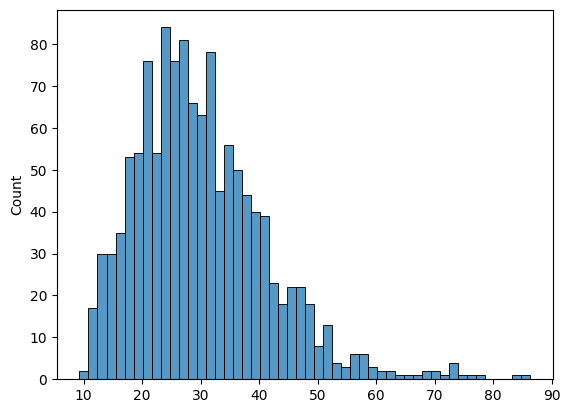

In [6]:
cell_mean_read_count = read_counts.to_numpy().mean(axis=1)
sns.histplot(cell_mean_read_count, bins=50)

<Axes: >

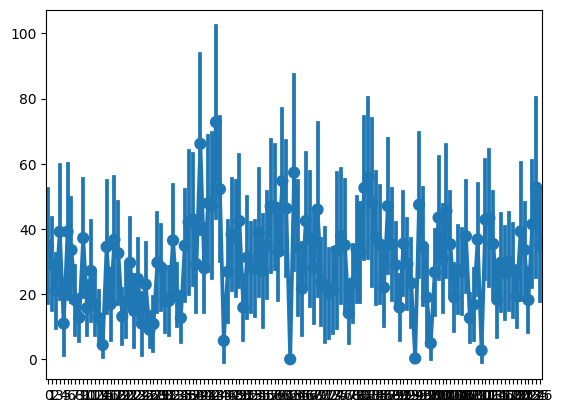

In [7]:
sns.pointplot(data = read_counts.to_numpy(), errorbar='sd')

<Axes: ylabel='Count'>

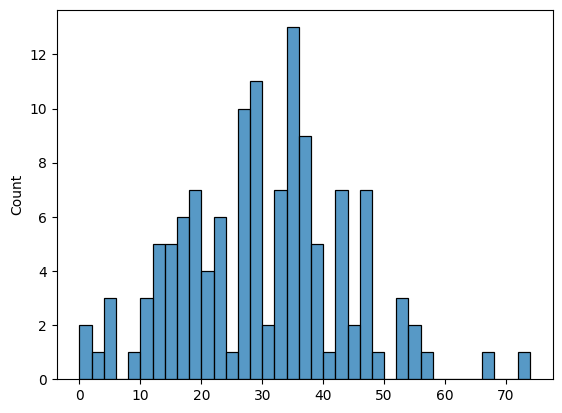

In [12]:
snv_mean_read_count = read_counts.to_numpy().mean(axis=0)
sns.histplot(snv_mean_read_count, bins=20, binwidth=2)

<Axes: >

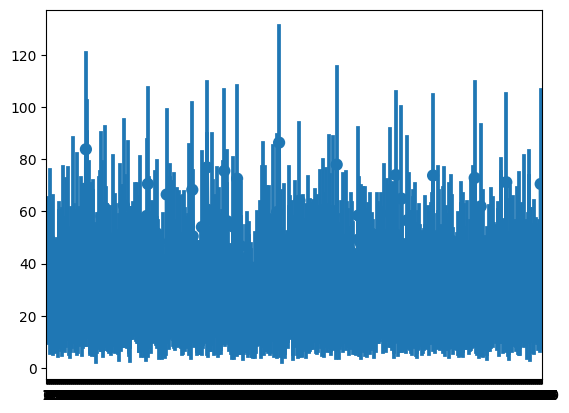

In [9]:
sns.pointplot(data = read_counts.to_numpy().T, errorbar='sd')

# HEATMAP

## SNV VAF

<Axes: >

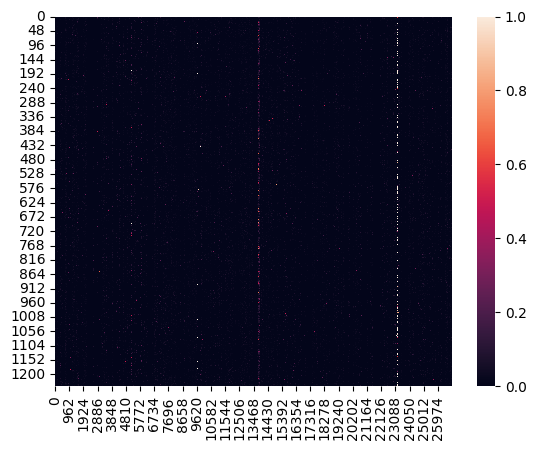

In [10]:
snv_vaf = vafs.to_numpy()
sns.heatmap(snv_vaf)

In [67]:
sns.clustermap(vafs.to_numpy())

c:\Users\sophi\anaconda3\envs\tapestri\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
c:\Users\sophi\anaconda3\envs\tapestri\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


: 

: 

## SNV 

In [56]:
variants.amplicon[variants.id == b'chr1:115256513:G/A'].values[0]

b'AML_v2_NRAS_115256512'

In [59]:
snv_read_count = vafs.copy()

for col in snv_read_count.columns:
    amplicon = variants.amplicon[variants.id == col].values[0]
    snv_read_count[col] = read_counts[amplicon]

In [60]:
snv_read_count

,b'chr1:115256513:G/A',b'chr1:115256513:G/T',b'chr1:115256514:G/A',b'chr1:115256515:C/',b'chr1:115256516:A/G',b'chr1:115256516:A/T',b'chr1:115256517:C/',b'chr1:115256518:T/C',b'chr1:115256518:T/G',b'chr1:115256519:G/',...,b'chr21:44524600:T/C',b'chr21:44524601:A/',b'chr21:44524602:C/',b'chr21:44524603:T/',b'chr21:44524604:T/',b'chr21:44524605:T/C',b'chr21:44524606:T/C',b'chr21:44524607:A/',b'chr21:44524608:A/G',b'chr21:44524609:C/'
b'AACAACCTACAGAAGTGA-1',37,37,37,37,37,37,37,37,37,37,...,30,30,30,30,30,30,30,30,30,30
b'AACAACCTATCTATGACA-1',11,11,11,11,11,11,11,11,11,11,...,26,26,26,26,26,26,26,26,26,26
b'AACAACTGGCAACGCACA-1',44,44,44,44,44,44,44,44,44,44,...,26,26,26,26,26,26,26,26,26,26
b'AACACACTCTTACAGTGT-1',59,59,59,59,59,59,59,59,59,59,...,46,46,46,46,46,46,46,46,46,46
b'AACAGCAGTCGTCTGCTG-1',31,31,31,31,31,31,31,31,31,31,...,40,40,40,40,40,40,40,40,40,40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
b'TTGGACTTCCGCTTATGA-1',9,9,9,9,9,9,9,9,9,9,...,16,16,16,16,16,16,16,16,16,16
b'TTGGAGAACTGAACTTGC-1',109,109,109,109,109,109,109,109,109,109,...,92,92,92,92,92,92,92,92,92,92
b'TTGGTAACTTCTGCGCTG-1',46,46,46,46,46,46,46,46,46,46,...,45,45,45,45,45,45,45,45,45,45
b'TTGTCAACCGCAGCAGTG-1',69,69,69,69,69,69,69,69,69,69,...,48,48,48,48,48,48,48,48,48,48


In [ ]:
sns.heatmap()

## CNA amplicon

<Axes: >

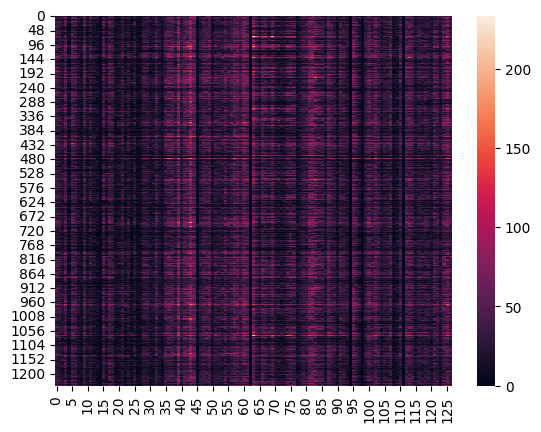

In [13]:
sns.heatmap(read_counts.to_numpy())

In [14]:
read_counts.sum(axis=1)

b'AACAACCTACAGAAGTGA-1'    4375
b'AACAACCTATCTATGACA-1'    2938
b'AACAACTGGCAACGCACA-1'    3361
b'AACACACTCTTACAGTGT-1'    4337
b'AACAGCAGTCGTCTGCTG-1'    5043
                           ... 
b'TTGGACTTCCGCTTATGA-1'    1923
b'TTGGAGAACTGAACTTGC-1'    8954
b'TTGGTAACTTCTGCGCTG-1'    4834
b'TTGTCAACCGCAGCAGTG-1'    4834
b'TTGTTAGAGAATCTCCTA-1'    5842
Length: 1240, dtype: int64

In [11]:
read_counts.apply(lambda x : x/read_counts.sum(axis=1), axis=0)

,b'AML_v2_NRAS_115256512',b'AML_v2_NRAS_115258635',b'AML_v2_DNMT3A_25457166',b'AML_v2_DNMT3A_25458540',b'AML_v2_DNMT3A_25459813',b'AML_v2_DNMT3A_25461902',b'AML_v2_DNMT3A_25463127',b'AML_v2_DNMT3A_25463515',b'AML_v2_DNMT3A_25464443',b'AML_v2_DNMT3A_25466642',...,b'AML_v2_ASXL1_31022741',b'AML_v2_ASXL1_31023032',b'AML_v2_ASXL1_31023285',b'AML_v2_ASXL1_31023578',b'AML_v2_RUNX1_36171592',b'AML_v2_RUNX1_36206703',b'AML_v2_RUNX1_36231714',b'AML_v2_RUNX1_36252844',b'AML_v2_U2AF1_44514570',b'AML_v2_U2AF1_44524438'
b'AACAACCTACAGAAGTGA-1',0.008457,0.006857,0.005257,0.009143,0.004571,0.013257,0.009143,0.003657,0.005486,0.007771,...,0.008457,0.008686,0.007543,0.004571,0.011657,0.007771,0.007543,0.010286,0.012114,0.006857
b'AACAACCTATCTATGACA-1',0.003744,0.006467,0.008509,0.007488,0.001702,0.008850,0.005446,0.005106,0.009190,0.015317,...,0.008509,0.008509,0.008169,0.008509,0.009190,0.011913,0.011232,0.011572,0.015997,0.008850
b'AACAACTGGCAACGCACA-1',0.013091,0.007736,0.002975,0.006843,0.007438,0.015472,0.008628,0.001785,0.005058,0.009521,...,0.005653,0.010711,0.008628,0.002975,0.014281,0.005951,0.002678,0.010711,0.010414,0.007736
b'AACACACTCTTACAGTGT-1',0.013604,0.007148,0.005073,0.010145,0.001614,0.007378,0.005534,0.002767,0.003689,0.009915,...,0.004381,0.004150,0.008301,0.005303,0.017293,0.010837,0.004381,0.010606,0.014526,0.010606
b'AACAGCAGTCGTCTGCTG-1',0.006147,0.006345,0.008328,0.014674,0.001785,0.015269,0.010906,0.004759,0.004164,0.011501,...,0.005552,0.006940,0.006940,0.004164,0.007139,0.007932,0.007139,0.012294,0.012096,0.007932
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
b'TTGGACTTCCGCTTATGA-1',0.004680,0.002080,0.009880,0.009880,0.004680,0.014041,0.015081,0.007280,0.006240,0.012480,...,0.011960,0.008320,0.005720,0.006760,0.013001,0.008320,0.002080,0.006760,0.010920,0.008320
b'TTGGAGAACTGAACTTGC-1',0.012173,0.000112,0.005584,0.011392,0.002122,0.007371,0.006031,0.004244,0.001564,0.008823,...,0.007929,0.006478,0.005026,0.004691,0.007259,0.005696,0.003350,0.014407,0.014854,0.010275
b'TTGGTAACTTCTGCGCTG-1',0.009516,0.009723,0.004137,0.011998,0.006413,0.012412,0.008275,0.004137,0.004137,0.011791,...,0.006206,0.004965,0.007861,0.004758,0.015722,0.010343,0.005792,0.011585,0.014067,0.009309
b'TTGTCAACCGCAGCAGTG-1',0.014274,0.008688,0.004137,0.010757,0.002276,0.014481,0.009723,0.003930,0.004344,0.011998,...,0.005792,0.006206,0.008275,0.002896,0.016343,0.009930,0.004758,0.009102,0.010343,0.009930


c:\Users\sophi\anaconda3\envs\tapestri\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


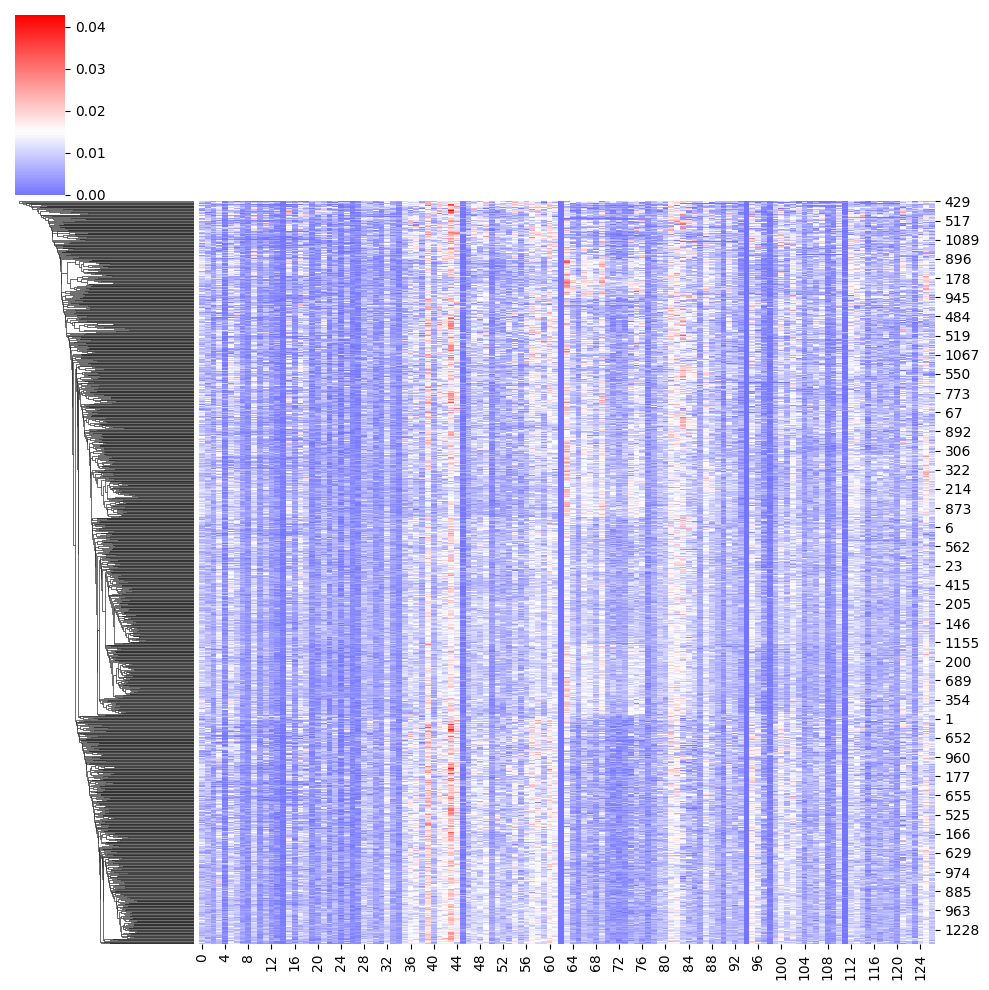

In [13]:
sns.clustermap((read_counts.apply(lambda x : x/read_counts.sum(axis=1), axis=0)).to_numpy(), col_cluster=False, cmap="bwr", center = 0.015)

<Axes: >

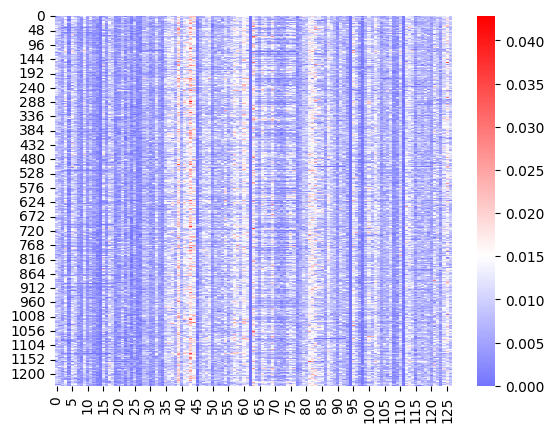

In [27]:
sns.heatmap((read_counts.apply(lambda x : x/read_counts.sum(axis=1), axis=0)).to_numpy(), cmap = "bwr", center = 0.015)


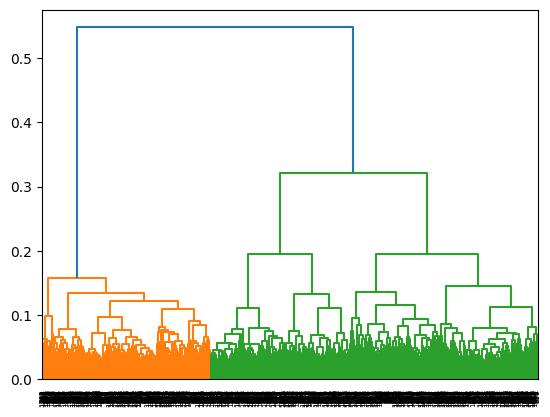

In [27]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
normalized_data = (read_counts.apply(lambda x : x/read_counts.sum(axis=1), axis=0)).to_numpy()

linkage_data = linkage(normalized_data, method='ward', metric='euclidean')
dendrogram(linkage_data)

plt.show()

In [35]:
clusters = fcluster(linkage_data, t=0.3 , criterion='distance')

In [44]:
kmeans_labels = cluster.KMeans(n_clusters=4).fit_predict(normalized_data)

c:\Users\sophi\anaconda3\envs\tapestri\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [49]:
standard_embedding = umap.UMAP(random_state=42).fit_transform(normalized_data)

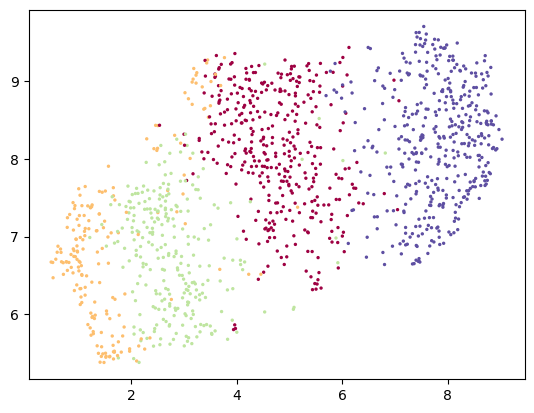

In [56]:
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=kmeans_labels, s=2, cmap ='Spectral')

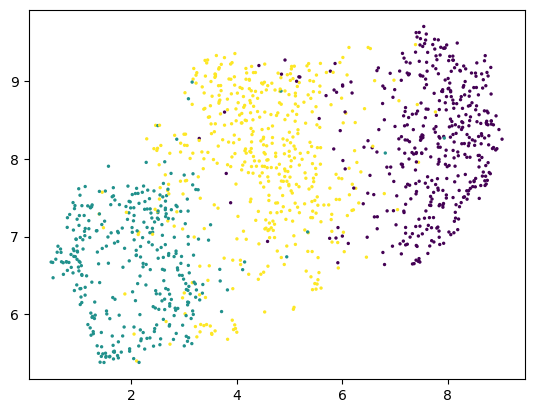

In [57]:
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=clusters, s=2)

In [58]:
import plotly.express as px
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA


pca = PCA()
pca.fit(normalized_data)
exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)

px.area(
    x=range(1, exp_var_cumul.shape[0] + 1),
    y=exp_var_cumul,
    labels={"x": "# Components", "y": "Explained Variance"}
)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'fillpattern': {'shape': ''},
              'hovertemplate': '# Components=%{x}<br>Explained Variance=%{y}<extra></extra>',
              'legendgroup': '',
              'line': {'color': '#636efa'},
              'marker': {'symbol': 'circle'},
              'mode': 'lines',
              'name': '',
              'orientation': 'v',
              'showlegend': False,
              'stackgroup': '1',
              'type': 'scatter',
              'x': array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,
                           15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,
                           29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,
                           43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,
                           57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,
                           71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,
                           85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,
                           99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112,
                          113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126,
                          127], dtype=int64),
              'xaxis': 'x',
              'y': array([0.16431526, 0.22268661, 0.26733163, 0.3062504 , 0.33729686, 0.36547652,
                          0.38740197, 0.40636245, 0.42269184, 0.43722626, 0.45086957, 0.46429161,
                          0.47707301, 0.48946263, 0.50159836, 0.51287154, 0.52368253, 0.53414171,
                          0.54439541, 0.55452084, 0.56429787, 0.57361048, 0.58281873, 0.59171856,
                          0.60048736, 0.60909364, 0.61764012, 0.62598622, 0.63403914, 0.64207155,
                          0.64987395, 0.65759156, 0.66509934, 0.67239094, 0.67964621, 0.68669999,
                          0.69363758, 0.70034525, 0.70700535, 0.71348707, 0.71993262, 0.72619737,
                          0.73243223, 0.7386253 , 0.74465202, 0.75065711, 0.75651366, 0.76224577,
                          0.76789011, 0.77347096, 0.77887593, 0.78425205, 0.78945634, 0.79456998,
                          0.79965927, 0.80468713, 0.8096729 , 0.81452613, 0.81929967, 0.82402433,
                          0.82871399, 0.83330742, 0.83780238, 0.84224401, 0.84666758, 0.85098697,
                          0.85522374, 0.85936612, 0.86347748, 0.86750001, 0.87148204, 0.87542158,
                          0.87931229, 0.88310279, 0.88682229, 0.89053591, 0.89415568, 0.89772922,
                          0.90122402, 0.90470386, 0.90812833, 0.91146886, 0.91473454, 0.91795909,
                          0.92113944, 0.92428743, 0.92735257, 0.93040975, 0.93334783, 0.93622116,
                          0.93907665, 0.94186338, 0.94461336, 0.94729911, 0.94990411, 0.95244029,
                          0.95495732, 0.95737901, 0.95972253, 0.96206044, 0.96426573, 0.96644613,
                          0.96858334, 0.97063383, 0.97265286, 0.97461894, 0.97658145, 0.97847935,
                          0.98036716, 0.98223984, 0.9840071 , 0.98570591, 0.98737283, 0.98901257,
                          0.99058002, 0.99203296, 0.99346144, 0.99477663, 0.99605776, 0.99728379,
                          0.99823744, 0.99908547, 0.99956115, 0.9999829 , 1.        , 1.        ,
                          1.        ]),
              'yaxis': 'y'}],
    'layout': {'legend': {'tracegroupgap': 0},
               'margin': {'t': 60},
               'template': '...',
               'xaxis': {'anchor': 'y', 'domain': [0.0, 1.0], 'title': {'text': '# Components'}},
               'yaxis': {'anchor': 'x', 'domain': [0.0, 1.0], 'title': {'text': 'Explained Variance'}}}
})

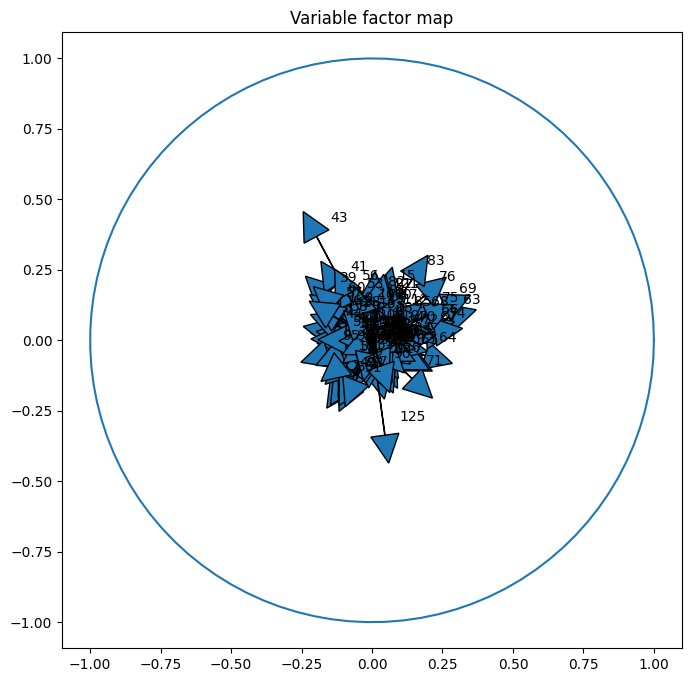

In [59]:
from sklearn.decomposition import PCA
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
 

 
n_components = 80 #scaled.shape[1]
 
# Do the PCA.
pca = PCA(n_components=n_components)
pca.fit_transform(np.copy(normalized_data))


# Plot a variable factor map for the first two dimensions.
(fig, ax) = plt.subplots(figsize=(8, 8))
for i in range(0, pca.components_.shape[1]):
    ax.arrow(0,
             0,  # Start the arrow at the origin
             pca.components_[0, i],  #0 for PC1
             pca.components_[1, i],  #1 for PC2
             head_width=0.1,
             head_length=0.1)

    plt.text(pca.components_[0, i] + 0.05,
             pca.components_[1, i] + 0.05,
             i)


an = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale
plt.axis('equal')
ax.set_title('Variable factor map')
plt.show()

SNV info 

- 43 : TET2
- 125 : U2AF1

In [63]:
amplicons.iloc[43]

CHROM                            b'4'
end_pos                     106158015
id           b'AML_v2_TET2_106157777'
r1_counts                       90216
r2_counts                       90230
start_pos                   106157757
Name: 43, dtype: object

In [64]:
amplicons.iloc[125]

CHROM                           b'21'
end_pos                      44514808
id           b'AML_v2_U2AF1_44514570'
r1_counts                       65367
r2_counts                       65269
start_pos                    44514550
Name: 125, dtype: object